# Therapy Session Classification

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import re
import os
import sys
import torch
import metal
import numpy as np

print('PyTorch: ', torch.__version__)
print('MeTaL:   ', metal.__version__)
print('Python:  ', sys.version)


PyTorch:  1.0.1
MeTaL:    0.4.1
Python:   3.6.7 | packaged by conda-forge | (default, Nov 20 2018, 18:37:09) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
#     """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
#     Arguments
#     ---------
#     confusion_matrix: numpy.ndarray
#         The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
#         Similarly constructed ndarrays can also be used.
#     class_names: list
#         An ordered list of class names, in the order they index the given confusion matrix.
#     figsize: tuple
#         A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
#         the second determining the vertical size. Defaults to (10,7).
#     fontsize: int
#         Font size for axes labels. Defaults to 14.
        
#     Returns
#     -------
#     matplotlib.figure.Figure
#         The resulting confusion matrix figure
#     """
#     df_cm = pd.DataFrame(
#         confusion_matrix, index=class_names, columns=class_names, 
#     )
#     fig = plt.figure(figsize=figsize)
#     try:
#         heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
#     except ValueError:
#         raise ValueError("Confusion matrix values must be integers.")
#     heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
#     heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     return fig

In [19]:
%%time

import pandas as pd
import spacy


class TherapyDataset(object):

    def __init__(self, 
                 data,
                 target='PHQ9',
                 mode='classification',
                 model_type='point'):

        self.data = data
        self.target = target.lower()
           
        # if we're looking at sequences of sessions, group data by patient and sort by session id
        if model_type == 'sequence':
            # TODO
            pass
        else:
            self.X, self.Y = zip(*self.data)
            
        # bin scores 
        digitize = 'binary'
        if mode == 'classification' and self.target == 'phq9':
            self.Y = self._get_phq9_score_bins(self.Y, digitize)

            
    def _get_phq9_score_bins(self, Ys, digitize):

        if digitize == 'multi':
#             clsmap = {
#                 (0,4)   : 1, # minimal
#                 (5,9)   : 2, # mild
#                 (10,14) : 3, # moderate
#                 (15,19) : 4, # moderate_severe
#                 (20,27) : 5, # severe
#             }

            bins = np.array([0, 4.5, 9.5, 14.5, 19.5, 28])
        elif digitize == 'binary':
            bins = np.array([0, 9.5, 28])
        return np.digitize(Ys, bins)
        
    def _process_text(self, s):
        pass
    
    @staticmethod
    def load_tsv(fpath, target):

        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
         
        dataset = {'train':[],'dev':[], 'test':[]}
        for i,row in pd.read_table(fpath).iterrows():
            pid = row['ID_number']
            sid = row['Num_sess']
            
            if row['train']:
                split = 'train'
            elif row['dev']:
                split = 'dev'
            else:
                split = 'test'
                
            x = row['text']
            # just include certain POS tag words
            doc = nlp(x)
            x_t = []
            for token in doc:
                if token.pos_ in set(['NOUN','VERB']): #set([,'ADJ','VERB']): # 'PROPN', 'NOUN', ,'ADJ'
                    x_t.append(token.text)
            x = " ".join(x_t)
            
            if target == 'phq9':
                y = row['PHQ9_total_ses']
            elif target == 'phq9_delta':
                y = row['PHQ9_total_ses_diff']
            else:
                y = row['PHQ9_total_ses_overall_diff']
            
            dataset[split].append((x,y))
        return dataset
    
    @classmethod
    def splits(cls, fpath, target, mode='classification', model_type='point'):
        data = TherapyDataset.load_tsv(fpath, target)
        return (cls(data['train'], target, mode, model_type), 
               cls(data['dev'], target, mode, model_type),
               cls(data['test'], target, mode, model_type))
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


train, dev, test = TherapyDataset.splits('scotty_supervised_learning_data_view.tsv', target='phq9')

print('[TRAIN]', len(train))
print('[DEV]  ', len(dev))
print('[TEST] ', len(test))


[TRAIN] 414
[DEV]   133
[TEST]  252
CPU times: user 11min 59s, sys: 49 s, total: 12min 48s
Wall time: 7min 31s


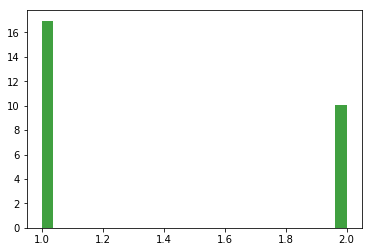

In [20]:
import matplotlib.pyplot as plt
y_dist = [y for x,y in train]

n, bins, patches = plt.hist(y_dist, 27, density=True, facecolor='g', alpha=0.75)

min 4
max 4374
mean 2505.557971014493
median 2515.5
	50% percentile: 2515.5
	90% percentile: 3263.8
	95% percentile: 3441.3499999999995
	100% percentile: 4374.0


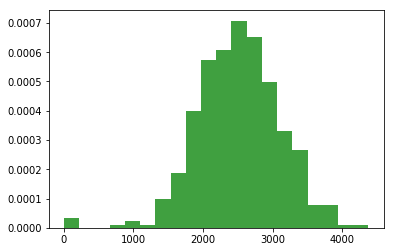

In [21]:
import itertools

doc_lens, phq9 = [], []
for x,y in train:
    tokens = x.split()
    doc_lens.append(len(tokens))
    phq9.append(y)

# compute summary statistics
print('min', np.min(doc_lens))
print('max', np.max(doc_lens))
print('mean', np.mean(doc_lens))
print('median', np.median(doc_lens))

for q in [50, 90, 95, 100]:
    print("\t{}% percentile: {}".format (q, np.percentile(doc_lens, q)))
    
n, bins, patches = plt.hist(doc_lens, 20, density=True, facecolor='g', alpha=0.75)

## Build Model

In [22]:
import nltk
from nltk.corpus import stopwords
sw = set(stopwords.words('english') + ["like","it's","i've","that's",'um',"i'm", "i'd",'oh',
                                       "you'll","wasn't","we've", "she's", "doesn't", "don't", "didn't",
                                       "who","what","why","whom",'yeah','lot',"i'll","uh","let's",
                                       "they're","he's","y'all", "'re",
                                       "we'll",'right','one','two','three','four','five','six','seven',
                                       'eight','nine', "'m", "'s", "'ll","'d","'ve",
                                       'went',"you're",'around',"you've","we're","there's",
                                       'else','also',"it'll"])

def filter_words(doc, stopwords=sw):
    return [t for t in doc if t.lower() not in stopwords]


In [23]:
import torch
from torch.utils.data import DataLoader
from utils import DocumentDataset, build_vocab, get_padded_seqs
    
n_classes    = 2
BATCH_SIZE   = 64
MAX_SEQ_LEN  = 4500 

X_train = [filter_words(x.split()) for x,y in train]
X_dev   = [filter_words(x.split()) for x,y in dev]
X_test  = [filter_words(x.split()) for x,y in test]


Y_train = [y for x,y in train]
Y_dev = [y for x,y in dev]
Y_test = [y for x,y in test]

# create 1-hot encoding
Y_train = np.array(Y_train) - 1
n_values = np.max(Y_train) + 1
Y_train = np.eye(n_values)[Y_train]

vocab = build_vocab(X_train)
print('Vocab:', vocab.len())

train_set = DocumentDataset(get_padded_seqs(X_train, vocab, MAX_SEQ_LEN), torch.tensor(Y_train))
dev_set   = DocumentDataset(get_padded_seqs(X_dev, vocab, MAX_SEQ_LEN), Y_dev)
test_set  = DocumentDataset(get_padded_seqs(X_test, vocab, MAX_SEQ_LEN), Y_test)

print(len(train_set))
print(len(dev_set))
print(len(test_set))


Vocab: 17669
414
133
252


### Data Loaders

In [24]:
def class_weights(dataset, n_classes):  
    
    n = [0] * n_classes 
    for x,y in dataset:
        y = torch.argmax(y)
        n[y] += 1
    class_weights = [0.0] * n_classes 
    for i in range(n_classes):
        class_weights[i] = sum(n)/float(n[i]) 
    print(class_weights)
    return torch.tensor([class_weights[torch.argmax(y)] for x,y in dataset])

w = class_weights(train_set, n_classes)
sampler = torch.utils.data.sampler.WeightedRandomSampler(w, len(w)) 


[1.5923076923076922, 2.688311688311688]


In [26]:
loaders = {}
loaders['train'] = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, sampler=sampler)
loaders['dev']   = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
loaders['test']  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


## Logistic Regression BoW

In [27]:
import torch
import torch.nn as nn
from metal.logging import LogWriter
from metal.end_model import EndModel
from metal.contrib.modules import EmbeddingsEncoder
from metal.contrib.modules.lstm_module import LSTMModule
from metal.logging.tensorboard import TensorBoardWriter
from metal.contrib.baselines.sparse_logreg import *
from metal.tuners import RandomSearchTuner

n_epochs      = 50

logreg = SparseLogisticRegression(
    input_dim=vocab.len(), 
    output_dim=n_classes
)

validation_metric = 'accuracy'

train_args = [
    loaders['train']
]
init_args = [
   [vocab.len(), n_classes]
]

init_kwargs = {
    "input_module": logreg, 
    "skip_head": True,
    "input_relu": False,
    "input_batchnorm": False,
    "use_cuda":torch.cuda.is_available(),
    'seed':123}

train_kwargs = {
    'n_epochs': n_epochs,
    'progress_bar': False,
    'validation_metric': validation_metric,
    'validation_freq': 1,   
    
    'checkpoint_config': {
       'checkpoint_best': True,
       'checkpoint_every': 1,
       'checkpoint_metric': validation_metric,
       'checkpoint_metric_mode': 'max',
       'checkpoint_dir': 'checkpoints',
       'checkpoint_runway': 0
    },

    'optimizer_config': {
        'optimizer': 'sgd',
        'optimizer_common': {'lr': 0.001},
        'sgd_config': {'momentum': 0.9},
        'adam_config': {'betas': (0.9, 0.999)},
        'rmsprop_config': {}
    },
    
    'lr_scheduler_config': {
        'lr_freeze': 0,
        'exponential_config': {'gamma': 0.9},
        'plateau_config': {
            'factor': 0.5,
            'patience': 10,
            'threshold': 0.0001,
            'min_lr': 0.0001
        }
    },
}

# Setting up log directory
log_config = {
    "log_dir": "./run_logs", 
    "run_name": 'phq9'
}

tuner_config = {"max_search": 3}
search_space = {
    "l2": [0.0],
    "lr": [0.001, 0.01, 0.1]
}

# Set up logger and searcher
tuner = RandomSearchTuner(EndModel, 
                             **log_config, 
                             validation_metric=validation_metric,
                             seed=1701)

# train end model
disc_model = tuner.search(
    search_space,
    loaders['dev'],
    train_args=train_args,
    init_args=init_args,
    init_kwargs=init_kwargs,
    train_kwargs=train_kwargs,
    max_search=tuner_config["max_search"],
    clean_up=False
)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): SparseLinearModule(
    (W): Embedding(17669, 2, padding_idx=0, sparse=True)
  )
)


Network architecture:
SparseLogisticRegression(
  (network): Sequential(
    (0): IdentityModule()
    (1): SparseLinearModule(
      (W): Embedding(17669, 2, padding_idx=0, sparse=True)
    )
  )
  (criteria): SoftCrossEntropyLoss()
)

[0] Testing {'l2': 0.0, 'lr': 0.001}
[1 epo]: TRAIN:[loss=46.809] VALID:[accuracy=0.556]
Saving model at iteration 1 with best score 0.556
[2 epo]: TRAIN:[loss=61.958] VALID:[accuracy=0.466]
[3 epo]: TRAIN:[loss=49.477] VALID:[accuracy=0.571]
Saving model at iteration 3 with best score 0.571
[4 epo]: TRAIN:[loss=35.021] VALID:[accuracy=0.571]
[5 epo]: TRAIN:[loss=36.776] VALID:[accuracy=0.481]
[6 epo]: TRAIN:[loss=25.375] VALID:[accuracy=0.556]
[7 epo]: TRAIN:[loss=25.713] VALID:[accuracy=0.571]
[8 epo]: TRAIN:[loss=24.623] VALID:[accuracy=0.556]
[9 epo]: TRAIN:[loss=14.631] VALID:[accuracy=0.519]
[10 epo

[12 epo]: TRAIN:[loss=101.004] VALID:[accuracy=0.564]
[13 epo]: TRAIN:[loss=42.432] VALID:[accuracy=0.526]
[14 epo]: TRAIN:[loss=126.170] VALID:[accuracy=0.549]
[15 epo]: TRAIN:[loss=74.298] VALID:[accuracy=0.571]
[16 epo]: TRAIN:[loss=88.864] VALID:[accuracy=0.534]
[17 epo]: TRAIN:[loss=90.562] VALID:[accuracy=0.541]
[18 epo]: TRAIN:[loss=95.944] VALID:[accuracy=0.571]
[19 epo]: TRAIN:[loss=81.720] VALID:[accuracy=0.549]
[20 epo]: TRAIN:[loss=118.600] VALID:[accuracy=0.541]
[21 epo]: TRAIN:[loss=213.275] VALID:[accuracy=0.549]
[22 epo]: TRAIN:[loss=45.551] VALID:[accuracy=0.541]
[23 epo]: TRAIN:[loss=20.743] VALID:[accuracy=0.571]
[24 epo]: TRAIN:[loss=66.074] VALID:[accuracy=0.489]
[25 epo]: TRAIN:[loss=42.025] VALID:[accuracy=0.519]
[26 epo]: TRAIN:[loss=46.244] VALID:[accuracy=0.549]
[27 epo]: TRAIN:[loss=49.399] VALID:[accuracy=0.526]
[28 epo]: TRAIN:[loss=26.048] VALID:[accuracy=0.541]
[29 epo]: TRAIN:[loss=72.996] VALID:[accuracy=0.579]
[30 epo]: TRAIN:[loss=49.674] VALID:[accur

### Test Set Scores

In [28]:
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, roc_auc_score

y_pred, y_true, y_proba = disc_model._get_predictions(loaders['test'], return_probs=True)
print(len(y_true))

#print(classification_report(y_true, y_pred, 
#      target_names=['minimal','mild','moderate','moderate_severe', 'severe']))
print(classification_report(y_true, y_pred, 
      target_names=['minimal_mild_moderate', 'moderate_severe']))

# print("Micro Average")
# print('P', precision_score(y_true, y_pred, average='micro'))
# print('R', recall_score(y_true,y_pred, average='micro'))
# print("\nMacro Average")
# print('P', precision_score(y_true, y_pred, average='macro'))
# print('R', recall_score(y_true, y_pred, average='macro'))

print('\nAUROC', roc_auc_score(y_true - 1, y_proba[...,1]))


252
                       precision    recall  f1-score   support

minimal_mild_moderate       0.66      0.75      0.71       158
      moderate_severe       0.47      0.36      0.41        94

            micro avg       0.61      0.61      0.61       252
            macro avg       0.57      0.56      0.56       252
         weighted avg       0.59      0.61      0.59       252


AUROC 0.5636277942364665


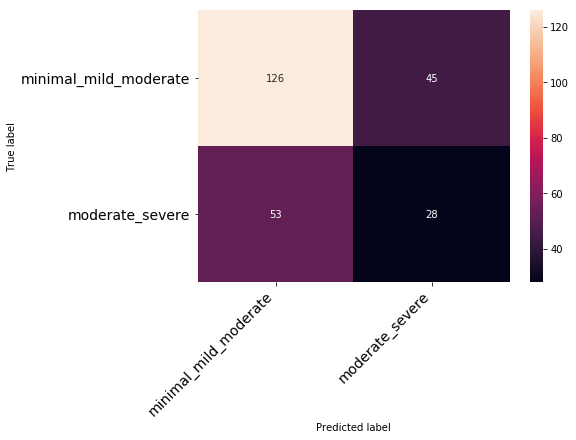

In [120]:
#class_names = ['minimal','mild','moderate','moderate_severe', 'severe']
class_names = ['minimal_mild_moderate', 'moderate_severe']
fig = print_confusion_matrix(confusion_matrix(y_true, y_pred), 
                       class_names=class_names,
                       figsize = (7,5), 
                       fontsize=14)


### Class Conditional Word Weights

In [29]:
weights = disc_model._modules['network']._modules['network']._modules['1'].W.weight

In [30]:
weights.size()
weights[...,0]

tensor([0.0000, 0.0013, 1.1768,  ..., 0.0313, 0.0226, 0.0356],
       grad_fn=<SelectBackward>)

In [31]:
# class_map = {
#     1: 'minimal',
#     2: 'mild',
#     3: 'moderate',
#     4: 'moderate_severe',
#     5: 'severe'
# }

class_map = {
    1: 'minimal_mild_moderate',
    2: 'moderate_severe'
}

def get_top_k_class_terms(w, vocab, top_k=50, n_classes=5):
    index2word = {i:w for w,i in vocab.d.items()}
    w = w.detach().numpy()
    for j in range(0,n_classes):
        
        # top negative weighted words
        print('=================\n{}\n================='.format(class_map[j+1].upper()))
        print("[Negative Weight]")
        idxs = np.argsort(w[...,j])[:top_k]
        #print(w[...,j][idxs])
        print([index2word[i] for i in idxs],"\n")
        
        print("[Positive Weight]")
        idxs = np.argsort(-w[...,j])[:top_k]
        #print(w[...,j][idxs])
        print([index2word[i] for i in idxs],"\n")
    
get_top_k_class_terms(weights, vocab, n_classes=n_classes)


MINIMAL_MILD_MODERATE
[Negative Weight]
['game', 'feels', 'father', 'play', 'stop', 'makes', 'find', 'homework', 'sounds', 'years', 'used', 'ca', 'started', 'continue', 'terms', 'knows', 'sleep', 'depression', 'help', 'picture', 'brother', 'study', 'asked', 'angel', 'insurance', 'exam', 'fit', 'helping', 'face', 'try', 'moment', 'top', 'relationships', 'ended', 'hospital', 'live', 'listen', 'anyone', 'means', 'group', 'explain', 'imagine', 'place', 'church', 'calling', 'moving', 'dad', 'going', 'bed', 'idea'] 

[Positive Weight]
['happen', 'done', 'school', 'telling', 'bit', 'friday', 'stress', 'working', 'somebody', 'looking', 'friends', 'step', 'write', 'told', 'today', 'break', 'lunch', 'car', 'message', 'spring', 'anxiety', 'side', 'thing', 'learning', 'fear', 'trying', 'avoid', 'mistakes', 'someone', 'rachel', 'pick', 'papers', 'part', 'seems', 'ask', 'decisions', 'seeing', 'letting', 'dinner', 'drive', 'might', 'anger', 'changes', 'snacks', 'professor', 'email', 'gone', 'binge', 